# 2_6 Orthofinder results analysis

Manuel Jara-Espejo$^{1}$\
Aboobaker lab, Department of Biology, University of Oxford

## Contents of notebook
1. Introduction
2. Customised orthology table from Orthofinder ouput
3. Analysis of Orthofinder results\
    3.1 Calling Orthogroups table\
    3.2 Identifying Parhyale genes shared with other species\
    3.3 Selecting all orthogroups shared between parhyale and other arthropods\
    3.4 Count genes shared between parhyale and specific species\
    3.5 Integrate and plot 1:1 orthogroups data with shared genes with each species

## Files
* Input: Blastp and Orthofinder outputs
* Output: 

### 1. Introduction

### 2. Customised orthology table from Orthofinder ouput

In [4]:
library(tidyr)
library(dplyr)
library(ggplot2)
library(reshape2)
library(tibble)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘ggplot2’ was built under R version 4.0.5”
Warning message:
“package ‘reshape2’ was built under R version 4.0.5”

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [6]:
#Open Orthofinder orthology output for four main model organisms
setwd("/drives/ssd1/manuel/phaw/2022_analysis/annotation/protein_coding_genes/")

phaw_dmel <- read.table("/drives/ssd1/manuel/phaw/2022_analysis/annotation/protein_coding_genes/orthofinder_analysis/proteomes/OrthoFinder/Results_Jul01/Orthologues/Orthologues_Phaw/Phaw__v__Dmel.tsv",
                         header = T,stringsAsFactors = F,sep = "\t")
phaw_hsa <- read.table("/drives/ssd1/manuel/phaw/2022_analysis/annotation/protein_coding_genes/orthofinder_analysis/proteomes/OrthoFinder/Results_Jul01/Orthologues/Orthologues_Phaw/Phaw__v__Hsa.tsv",
                        header = T,stringsAsFactors = F,sep = "\t")
phaw_cele <- read.table("/drives/ssd1/manuel/phaw/2022_analysis/annotation/protein_coding_genes/orthofinder_analysis/proteomes/OrthoFinder/Results_Jul01/Orthologues/Orthologues_Phaw/Phaw__v__Cele.tsv",
                       header = T,stringsAsFactors = F,sep = "\t")
phaw_xtrop <- read.table("/drives/ssd1/manuel/phaw/2022_analysis/annotation/protein_coding_genes/orthofinder_analysis/proteomes/OrthoFinder/Results_Jul01/Orthologues/Orthologues_Phaw/Phaw__v__Xtrop.tsv",
                        header = T,stringsAsFactors = F,sep = "\t")
phaw_orthogroups <- read.table("/drives/ssd1/manuel/phaw/2022_analysis/annotation/protein_coding_genes/orthofinder_analysis/proteomes/OrthoFinder/Results_Jul01/Orthogroups/Orthogroups.tsv",
                               header = T,stringsAsFactors = F,sep = "\t")
phaw_TF <- read.table("/drives/ssd1/manuel/phaw/2022_analysis/annotation/protein_coding_genes/pfam_search/TF_ids.txt")
colnames(phaw_TF) <- c("Phaw")
#phaw_TF$Phaw <- paste0("Phaw_",phaw_TF$Phaw)
phaw_TF$class <- "TF"

#Merge Phaw ortholog tables with TF dataframe
phaw_orthologs_df <- Reduce(function(x, y) merge(x, y, all=TRUE, by = "Phaw"), list(phaw_dmel,phaw_hsa,phaw_cele,phaw_xtrop), accumulate=FALSE)

phaw_orthologs_df <- merge(phaw_orthologs_df[,-c(2,4,6,8)] %>% tibble() %>% mutate(Phaw = gsub("Phaw_","",Phaw)) %>% separate_rows(Phaw)%>%
  separate(Phaw,into = c("gene", "transcript","pep"), sep = "\\.") %>% filter(pep != "NA") %>%
  mutate(gene=paste(gene,transcript,sep=".")) %>% dplyr::select(-c(transcript,pep)),
  phaw_TF,by.x="gene",by.y="Phaw",all=TRUE)

phaw_orthologs_df %>% head(5)
#write.table(phaw_orthologs_df,"phaw_orthologs_df.txt",row.names = F,col.names = T,quote = F,sep = "\t")  

Warning message in merge.data.frame(x, y, all = TRUE, by = "Phaw"):
“column names ‘Orthogroup.x’, ‘Orthogroup.y’ are duplicated in the result”
Warning message:
“Expected 3 pieces. Additional pieces discarded in 10826 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


,gene,Dmel,Hsa,Cele,Xtrop,class
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,MSTRG.1000,Dmel_tr|Q9VEC2|Q9VEC2_DROME,Hsa_sp|Q969U7|PSMG2_HUMAN,NA,Xtrop_sp|Q5XGC5|PSMG2_XENTR,NA
2,MSTRG.10000,Dmel_tr|Q9VSW1|Q9VSW1_DROME,Hsa_sp|Q16851|UGPA_HUMAN,NA,NA,NA
3,MSTRG.10003,NA,NA,NA,NA,TF
4,MSTRG.10004,Dmel_tr|Q9VXB1|Q9VXB1_DROME,Hsa_sp|Q14CZ0|CP072_HUMAN,NA,Xtrop_sp|Q28HY5|CP072_XENTR,NA
5,MSTRG.10006,Dmel_sp|Q9VYV3|TXND5_DROME,Hsa_sp|Q8NBS9|TXND5_HUMAN,NA,NA,NA


### 3. Analysis of Orthofinder results

#### 3.1 Calling Orthogroups table

In [59]:
orthogroups = read.table("/drives/ssd1/manuel/phaw/2022_analysis/annotation/protein_coding_genes/orthofinder_analysis/proteomes/OrthoFinder/Results_Jul01/Orthogroups/Orthogroups.tsv",sep='\t',header = T)
#All orthogroups
orthogroups %>% nrow()

#Number of orthogroups containing Parhyale genes
orthogroups %>% filter(Phaw != "") %>% nrow()

#Selecting only orthogroups having Parhyale genes and shared with at least one species (remove those OG parhyale-specific)
orthogroups <- orthogroups %>% filter(Phaw != "") %>% 
relocate(Phaw, .after = Orthogroup) %>% 
mutate_all(~na_if(., ''))%>% filter_at(3:29, any_vars(!is.na(.))) 
orthogroups %>% nrow()

[1] 40130

[1] 9078

[1] 8532

#### 3.2 Identifying Parhyale genes shared with other species

In [45]:
#Select OG containing phaw genes
phaw_ortho <- orthogroups %>% select(Orthogroup, Phaw) %>%
  filter(Phaw != "") %>% separate_rows(Phaw ,sep = ", ")
#Parhyale genes in orthogroups
phaw_ortho %>% select(Phaw) %>% unique() %>% nrow() 

[1] 16978

#### 3.3 Selecting all orthogroups shared between parhyale and other arthropods

In [48]:
arthtopod_orthogroups <- orthogroups %>% select(Orthogroup,Aaeg,Amel,Bger,Dmag,Dmel,Dpul,Hazt,Pvan,Tcas) %>%
filter(Orthogroup %in% phaw_ortho$Orthogroup) %>% mutate_all(~na_if(., ''))%>% filter_at(2:10, any_vars(!is.na(.))) %>% pull(Orthogroup)
arthtopod_orthogroups %>% length

[1] 8362

#### 3.4 Count genes shared between parhyale and specific species

In [53]:
species <- vector()
genes <- vector()
groups <- vector()
for ( i in 1:27){
    species[i] <- colnames(orthogroups)[i+2]
    genes[i] <- orthogroups %>% select(Orthogroup,Phaw,i+2) %>% drop_na(3) %>%  select(Orthogroup, Phaw) %>%  separate_rows(Phaw ,sep = ", ") %>% count %>% pull
    groups[i] <- orthogroups %>% select(Orthogroup,Phaw,i+2) %>% drop_na(3) %>%  select(Orthogroup) %>%  count %>% pull
}
phaw_stats <- data.frame(species,genes,groups) 
phaw_stats %>% arrange(-groups) %>% head(5)

,species,genes,groups
,<chr>,<int>,<int>
1,Hazt,15356,7926
2,Pvan,12275,6095
3,Bger,11287,5679
4,Smim,11174,5600
5,Dmag,10973,5532


#### 3.5 Integrate and plot 1:1 orthogroups data with shared genes with each species

In [57]:
orthogroups_121 = read.table("/drives/ssd1/manuel/phaw/2022_analysis/annotation/protein_coding_genes/orthofinder_analysis/proteomes/OrthoFinder/Results_Jul01/Comparative_Genomics_Statistics/OrthologuesStats_one-to-one.tsv",sep='\t',header = T)
orthogroups_121 %>% filter(X == "Phaw")

X,Aaeg,Amel,Aqueen,Bflor,Bger,Bmal,Cele,Dmag,Dmel,⋯,Nvect,Nvit,Phaw,Pvan,Smar,Smed,Smim,Tcas,Tspir,Xtrop
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Phaw,4214,4823,2634,3784,4831,1776,3053,4827,4477,⋯,3320,4607,0,5290,4183,1994,4189,4859,2456,1754


Using species as id variables



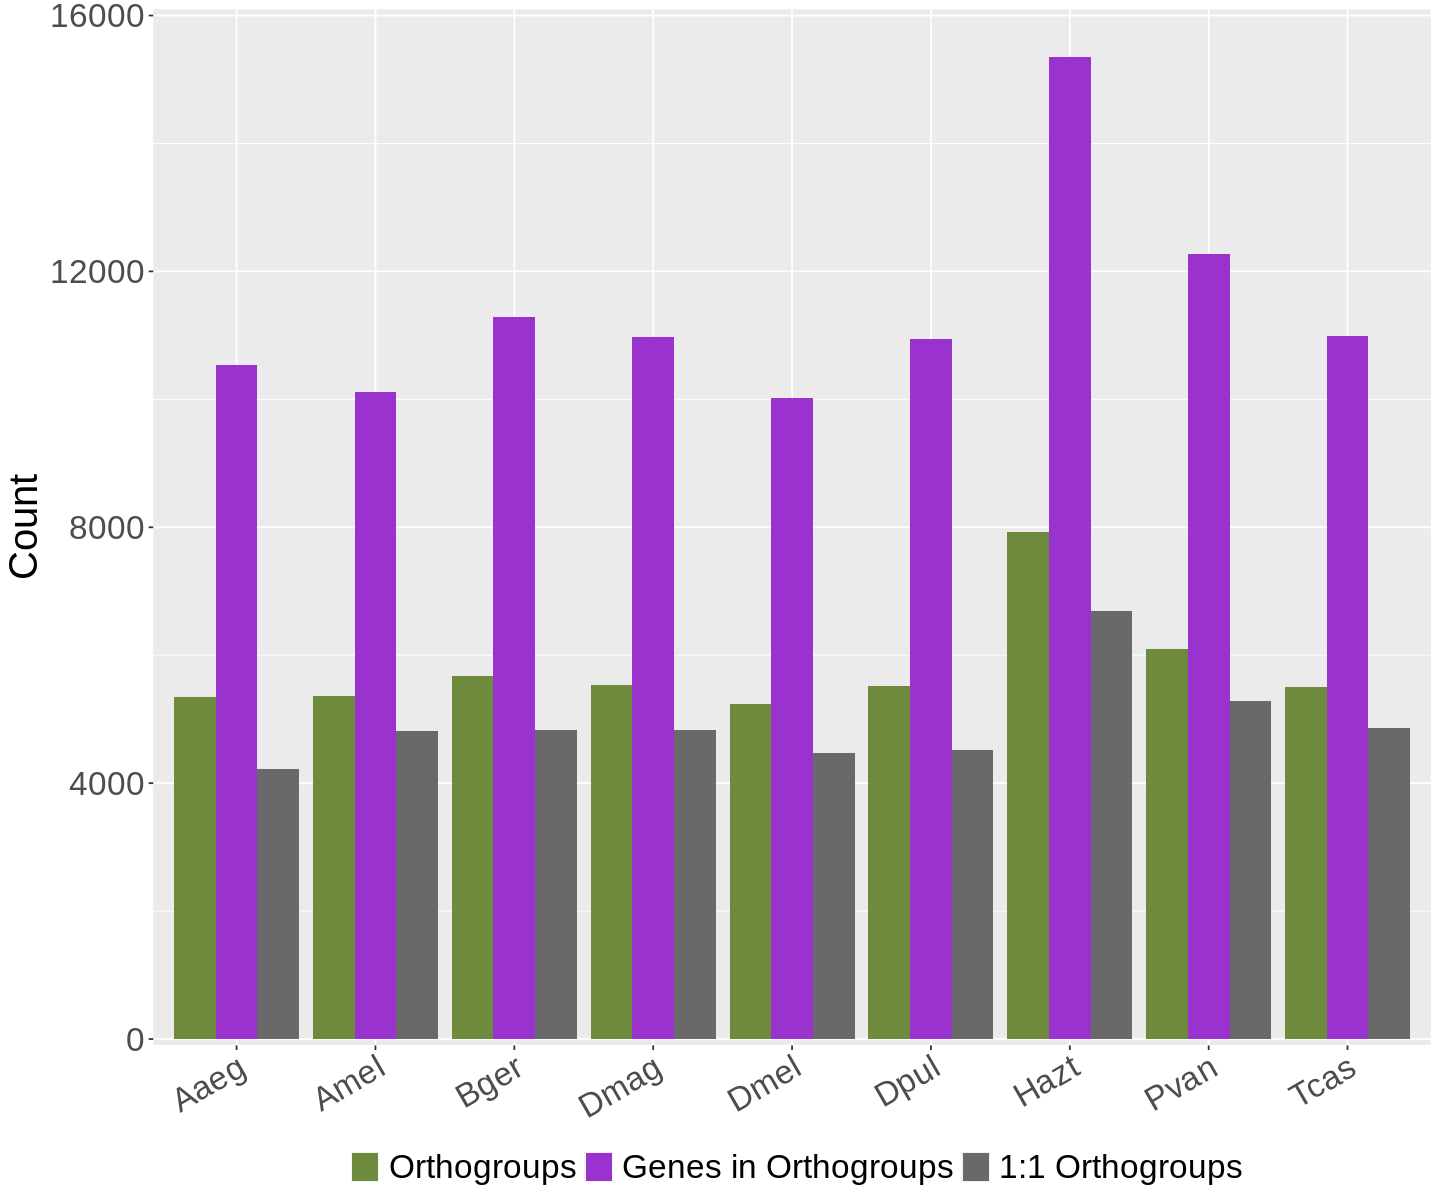

In [58]:
options(repr.plot.width=12, repr.plot.height=10)
 
arthropods_shredOG <- merge(phaw_stats,
      orthogroups_121 %>% filter(X == "Phaw") %>% pivot_longer(cols = Aaeg:Xtrop,names_to = "species",values_to = "og121") %>% select(-X), by= "species") %>%
filter(species %in% c("Aaeg","Amel","Bger","Dmag","Dmel","Dpul","Hazt","Pvan","Tcas")) %>%
mutate(species = factor(species)) %>% rename("Genes in Orthogroups"="genes","Orthogroups"="groups","1:1 Orthogroups"="og121")  %>% melt() %>%
mutate(variable= factor(variable,levels= c("Orthogroups","Genes in Orthogroups","1:1 Orthogroups"))) %>%
ggplot(aes(x=species, y=value, fill=variable)) + xlab(NULL) + ylab("Count") +
 scale_fill_manual(values=c("darkolivegreen4","darkorchid3","dimgray")) +
  geom_bar(stat="identity", position=position_dodge()) + scale_y_continuous(limits = c(0,16000), expand = c(0, 100)) +
    theme(plot.title = element_text(size=20, hjust = 0.5),legend.position = "bottom",legend.title=element_blank(),
          axis.text.x = element_text(angle = 30, hjust = 1), axis.title = element_text(size = 24),
          axis.text = element_text(size = 20),legend.text = element_text(size = 20))

#tiff("arthropods_shredOG.tiff",width = 9,height = 6.5,units = "in",res=400,compression = "lzw")
arthropods_shredOG
#dev.off()